In [ ]:
!pip install pywph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install torch

In [ ]:
!git clone https://github.com/jfrob27/pywavan.git

Cloning into 'pywavan'...
remote: Enumerating objects: 524, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 524 (delta 29), reused 34 (delta 16), pack-reused 470 (from 1)
Receiving objects: 100% (524/524), 7.05 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (292/292), done.


In [ ]:
!pip install pywavan/

Processing ./pywavan
  Preparing metadata (setup.py) ... done
  Created wheel for pywavan: filename=pywavan-0.1-py3-none-any.whl size=21508 sha256=4765db002058df4d50a79c1631daecb725982f9a3fe1ab8c8e3404a06420d4fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-49xqt2f5/wheels/c3/df/5a/a38957d32f204fadb637d615d544c92413636899b77433d834
Successfully built pywavan


In [ ]:
!pip uninstall pywavan

In [ ]:
!git clone https://github.com/constantauclair/CompSep.git

Cloning into 'CompSep'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 218 (delta 33), reused 36 (delta 12), pack-reused 96 (from 1)
Receiving objects: 100% (218/218), 63.17 MiB | 32.54 MiB/s, done.
Resolving deltas: 100% (79/79), done.


# generating ISM

Populating the interactive namespace from numpy and matplotlib


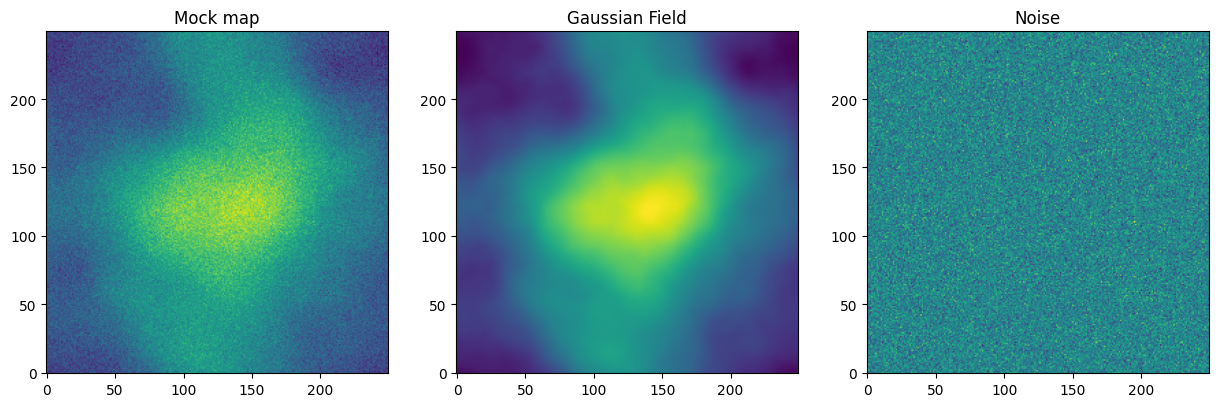

In [ ]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def gen_gaussian_field(nx, ny, gamma, seed=None):
    if seed is not None:
      np.random.seed(seed)

    x = np.fft.fftfreq(nx).reshape(nx, 1)
    y = np.fft.fftfreq(ny).reshape(1, ny)
    k_squared = x**2 + y**2 #in fourier space
    k_squared[0, 0] = 1.0  # Avoid division by zero at the origin

    # P(k) ~ k^gamma
    ps = k_squared ** (gamma)


    random_phases = np.exp(2j * np.pi * np.random.rand(nx, ny))
    fourier_field = random_phases * np.sqrt(ps)


    field = np.fft.ifft2(fourier_field).real

    # Normalize the field
    field -= field.mean()
    field /= field.std()

    return field


nx = 250
ny = 250
gamma = -2.5

# Generate the Gaussian random field
radio_halo = gen_gaussian_field(nx, ny, gamma, seed=2500)
n_std = 0.3
n = np.random.normal(0, n_std, size=(nx, ny))#noise (mean(centered at zero), std to control noise amp)
s = radio_halo

d = s+n

plt.figure(figsize(15, 15))
plt.subplot(1,3,1)
plt.imshow(d, cmap='viridis', origin='lower')
plt.title("Mock map")


plt.subplot(1,3,2)
plt.imshow(s, cmap='viridis', origin='lower')
plt.title("Gaussian Field")


plt.subplot(1,3,3)
plt.imshow(n, cmap='viridis', origin='lower')
plt.title("Noise")

plt.show()

hdu = fits.PrimaryHDU(data=s)
hdu.writeto('gaussian_field.fits', overwrite=True)



---



##component separation in the simulated mock map

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import torch
import scipy
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pywph as pw
import os
cwd = os.getcwd()
import sys
sys.path.append(cwd)
from CompSep.Library.comp_sep_functions import create_batch, compute_bias_std, compute_mask, compute_loss_BR, compute_loss_JMD
from CompSep.Library.tools import plot, powspec, plot_PS, plot_wph

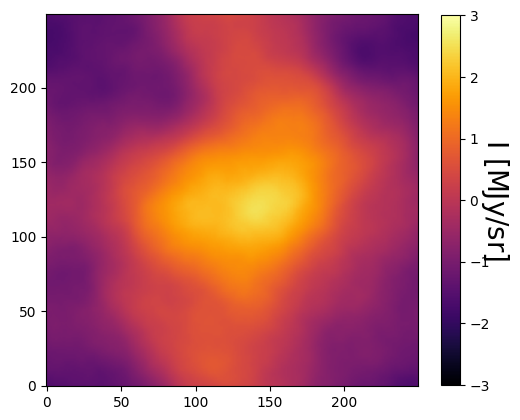

In [ ]:
plot(s)#S map


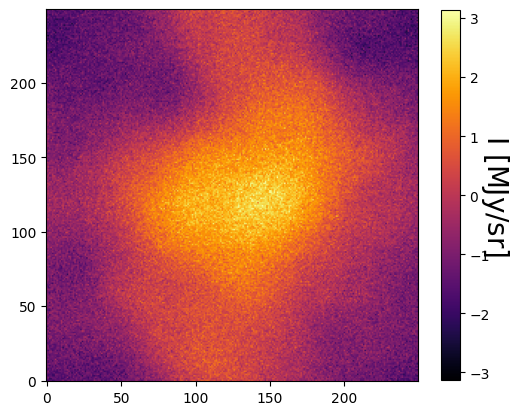

In [ ]:
plot(d)#mock map

In [ ]:
import numpy as np
np.save('d.npy', d)

In [ ]:
np.save("s_halo.npy", s)

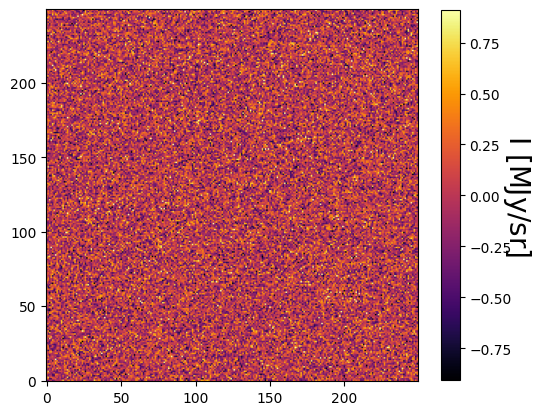

In [ ]:
plot(n)#contamination CIB

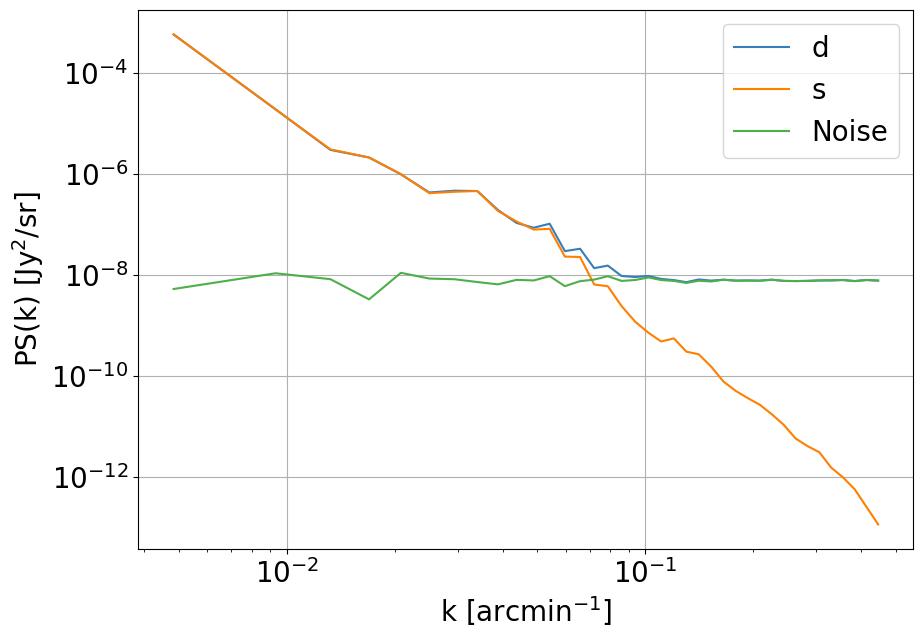

In [ ]:
plot_PS(np.array([d,s,n]),labels=['d','s','Noise'])

In [ ]:
Mn = 60 #noise realization
n_std = 0.3
noise = np.random.normal(0,n_std,size=(Mn,nx,ny)).astype(np.float64)


In [ ]:
N, N = np.shape(s) # map size
J = int(np.log2(N))-2 # number of scales
L = 4 # number of angles
pbc = True # periodic boundary conditions
dn = 5 # number of translations
wph_model = ["S11","S00","S01","Cphase","C01","C00","L"] # list of WPH coefficients

In [ ]:
style = 'BR'
method = 'L-BFGS-B'
n_epoch = 5
n_iter = 50
device = 0
batch_size = 5

In [ ]:
style = 'BR'
method = 'L-BFGS-B'
n_epoch = 5
n_iter = 50
device = "cpu"
batch_size = 5

In [ ]:
#alternative approach for minimalization
styles = ['JMD', 'BR']
method = 'L-BFGS-B'
n_epoch = 4
n_iter = 50
device = 0
batch_size = 5

In [ ]:
batch_number = int(Mn/batch_size)
n_batch = create_batch(noise, device, batch_number, batch_size, N)
wph_op = pw.WPHOp(N, N, J, L=L, dn=dn, device=device)

#computing loss function and gradient

In [ ]:
def objective(x):
    """
    Computes the loss and the corresponding gradient.

    Parameters
    ----------
    x : torch 1D tensor
        Flattened running map.

    Returns
    -------
    float
        Loss value.
    torch 1D tensor
        Gradient of the loss.

    """
    global eval_cnt
    global loss_list
    start_time = time.time()
    u = x.reshape((N, N)) # Reshape x
    u = torch.from_numpy(u).to(device).requires_grad_(True) # Track operations on u
    if style == 'BR':
        L = compute_loss_BR(u, coeffs_target, std, mask, device, Mn, wph_op, noise, pbc) # Compute the loss 'à la Bruno'
    if style == 'JMD':
        L = compute_loss_JMD(u, coeffs_target, std, mask, device, wph_op, pbc) # Compute the loss 'à la Jean-Marc'
    u_grad = u.grad.cpu().numpy().astype(x.dtype) # Compute the gradient
    if eval_cnt % 5 == 0:
        print(f"Evaluation: {eval_cnt}")
        print("L = "+str(round(L.item(),5)))
        print("(computed in "+str(round(time.time() - start_time,3))+"s)")
        print("")
    eval_cnt += 1
    loss_list.append(L.item())
    return L.item(), u_grad.ravel()

#only power spectrum term(S11 coefficient)

Starting epoch 1...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 107.10645
(computed in 2.719s)

Evaluation: 5
L = 8.85541
(computed in 2.361s)

Evaluation: 10
L = 0.83608
(computed in 2.358s)

Evaluation: 15
L = 0.59137
(computed in 2.351s)

Evaluation: 20
L = 0.45641
(computed in 2.382s)

Evaluation: 25
L = 0.38041
(computed in 2.712s)

Evaluation: 30
L = 0.34391
(computed in 2.505s)

Evaluation: 35
L = 0.31907
(computed in 2.561s)

Evaluation: 40
L = 0.30151
(computed in 2.59s)

Evaluation: 45
L = 0.28269
(computed in 2.636s)

Evaluation: 50
L = 0.27074
(computed in 2.667s)

Epoch 1 done !


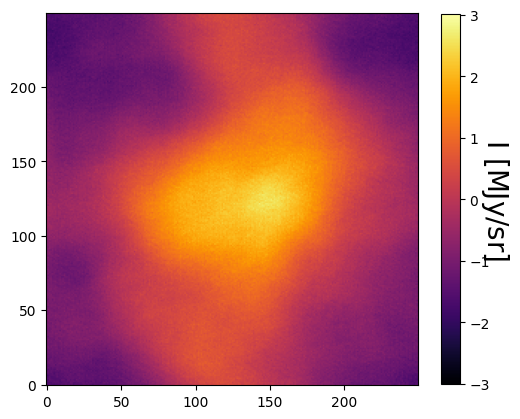

Starting epoch 2...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 55
L = 1.72562
(computed in 2.48s)

Evaluation: 60
L = 1.4313
(computed in 2.438s)

Evaluation: 65
L = 1.34898
(computed in 2.414s)

Evaluation: 70
L = 1.28919
(computed in 2.43s)

Evaluation: 75
L = 1.2444
(computed in 2.394s)

Evaluation: 80
L = 1.21801
(computed in 2.412s)

Evaluation: 85
L = 1.20313
(computed in 2.408s)

Evaluation: 90
L = 1.188
(computed in 2.396s)

Evaluation: 95
L = 1.17389
(computed in 2.386s)

Evaluation: 100
L = 1.16047
(computed in 2.396s)

Evaluation: 105
L = 1.14782
(computed in 2.374s)

Epoch 2 done !


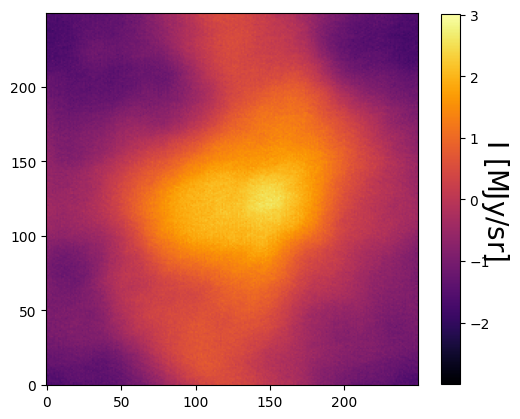

Starting epoch 3...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 110
L = 1.45962
(computed in 2.383s)

Evaluation: 115
L = 1.41112
(computed in 2.368s)

Evaluation: 120
L = 1.37493
(computed in 2.396s)

Evaluation: 125
L = 1.35362
(computed in 2.447s)

Evaluation: 130
L = 1.33973
(computed in 2.39s)

Evaluation: 135
L = 1.33348
(computed in 2.408s)

Evaluation: 140
L = 1.32958
(computed in 2.4s)

Evaluation: 145
L = 1.32601
(computed in 2.402s)

Evaluation: 150
L = 1.32121
(computed in 2.413s)

Evaluation: 155
L = 1.31675
(computed in 2.44s)

Evaluation: 160
L = 1.32158
(computed in 2.499s)

Epoch 3 done !


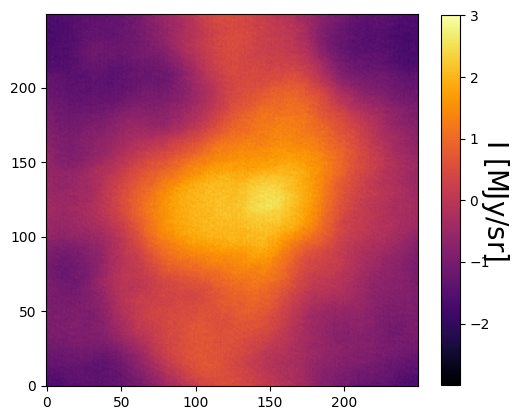

Starting epoch 4...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 165
L = 1.42589
(computed in 2.608s)

Evaluation: 170
L = 1.39814
(computed in 2.577s)

Evaluation: 175
L = 1.3862
(computed in 2.513s)

Evaluation: 180
L = 1.37771
(computed in 2.462s)

Evaluation: 185
L = 1.37377
(computed in 2.427s)

Evaluation: 190
L = 1.37102
(computed in 2.411s)

Evaluation: 195
L = 1.36918
(computed in 2.425s)

Evaluation: 200
L = 1.36625
(computed in 2.384s)

Evaluation: 205
L = 1.36191
(computed in 2.383s)

Evaluation: 210
L = 1.35778
(computed in 2.378s)

Evaluation: 215
L = 1.35551
(computed in 2.369s)

Epoch 4 done !


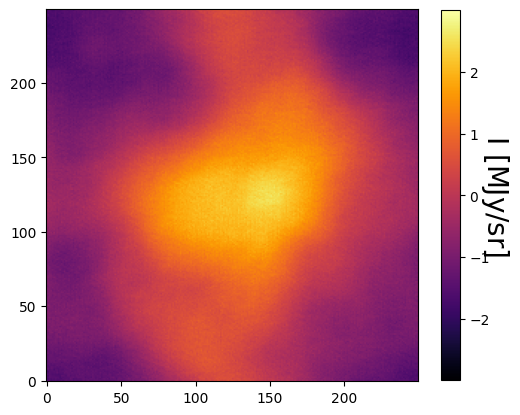

Starting epoch 5...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 95 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 220
L = 1.44822
(computed in 2.42s)

Evaluation: 225
L = 1.4378
(computed in 2.396s)

Evaluation: 230
L = 1.43021
(computed in 2.374s)

Evaluation: 235
L = 1.42647
(computed in 2.401s)

Evaluation: 240
L = 1.42393
(computed in 2.431s)

Evaluation: 245
L = 1.42266
(computed in 2.398s)

Evaluation: 250
L = 1.42149
(computed in 2.38s)

Evaluation: 255
L = 1.42006
(computed in 2.381s)

Evaluation: 260
L = 1.41877
(computed in 2.386s)

Evaluation: 265
L = 1.41736
(computed in 2.373s)

Epoch 5 done !


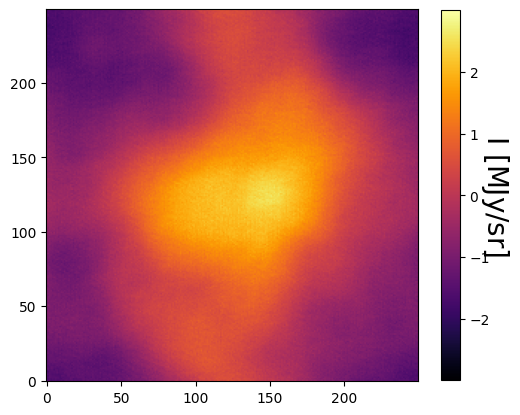

In [ ]:
# Initialization of evaluation count.(L-BFGS-B method)
eval_cnt = 0
# Initialization of the running map s_tilde0.
s_tilde0 = d
# Creation of the loss list.
loss_list = []
# WPH model loading (only the power-spectrum-like coefficients in the first step).
wph_op.load_model(["S11"])
# Loop of the epochs.
for i in range(n_epoch):
    print("Starting epoch "+str(i+1)+"...")
    # Bring s_tilde0 from array to tensor.
    s_tilde0 = torch.from_numpy(s_tilde0).to(device)
    print('Computing loss arguments...')
    # Computation of the noise-induced bias and std on the s_tilde0 map.
    # The bias is only used for style='JMD', but is computed
    # in both cases (no significant additional calculations).
    bias, std = compute_bias_std(s_tilde0, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    # Computation of the WPH statistics of "d".
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'BR':
        # In BR's formalism, the target WPH coefficients are the ones of "d".
        # They are split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),
                                   torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JMD':
        # In JMD's formalism, the target WPH coefficients are computed as
        # the ones of "d" corrected from the bias estimated before.
        # They are here also split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),
                                   torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    # Computation of the mask for the WPH statistics threshold.
    mask = compute_mask(1, s_tilde0, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    # Beginning of the optimization.
    result = opt.minimize(objective, s_tilde0.cpu().ravel(), method=method, jac=True, tol=None,
                          options={"maxiter": n_iter, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde0, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    # Reshaping of the running map s_tilde0.
    s_tilde0 = s_tilde0.reshape((N, N)).astype(np.float64)
    print("Epoch "+str(i+1)+" done !")
    plot(s_tilde0)
    # plot_PS(
    #     np.array([d,imtot,s_tilde0]),
    #     labels=['d', 's', 's_tilde0 (Epoch ' + str(i + 1) + ')'],
    #     colors=['blue','orange','black'],
    #     styles=['-','-','--']
    #     )




In [ ]:
np.save('separated_component_stilde0.npy', s_tilde0)

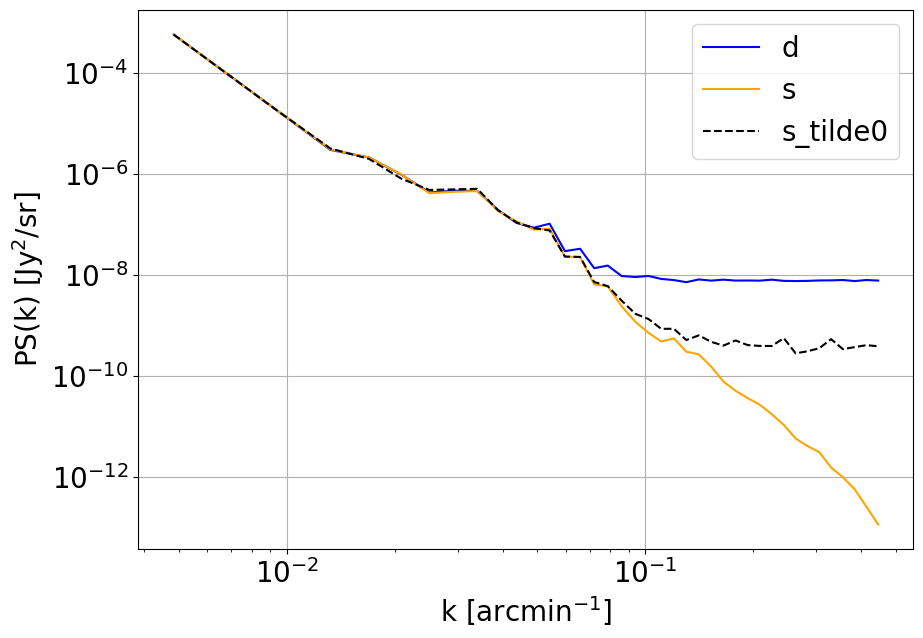

In [ ]:
plot_PS(
        np.array([d,s,s_tilde0]),
        labels=['d','s','s_tilde0'],
        colors=['blue','orange','black'],
        styles=['-','-','--']
        )

In [ ]:
def plot_PS_errorbar(images,labels=None,colors=None,styles=None,reso=1,apo=0.95,N_bin=40,lin_log_trans=3,cross=None,ret_PS=False,abs_cross=True,axis='k',fontsize=20,plot=True):
    if axis == 'k':
        k_to_l = 1
    if axis == 'l':
        k_to_l = 2 * 60 * 180
    if len(np.shape(images)) == 2:
        (M,N) = np.shape(images)
        n = 1
        t = 1
    if len(np.shape(images)) == 3:
        (n,M,N) = np.shape(images)
        t = 1#previously value to be 1
    if len(np.shape(images)) == 4:
        (t,n,M,N) = np.shape(images)
    if len(np.shape(images)) != 2 and len(np.shape(images)) != 3 and len(np.shape(images)) != 4:
        print("Invalid data shape !")
    if labels is None:
        labels = np.arange(1,n+1).astype(str).tolist()
    if colors is None:
        colors = color[:n]
    if styles is None:
        styles = ['-']*n
    print("t=",t)
    print("------------------------------------------------------------------------------------------------")
    if t == 1:
        # PS computation
        if n == 1:
            PS = powspec(images,reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans)
        else:
            PS = []
            for i in range(n):
                PS.append(powspec(images[i],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans))
            if cross is not None:
                for i in range(len(cross)):
                    if not abs_cross:
                        PS.append(powspec(images[cross[i][0]],im2=images[cross[i][1]],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans))
                    else:
                        PS.append(np.abs(powspec(images[cross[i][0]],im2=images[cross[i][1]],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans)))
        PS = np.array(PS)
        # Plot
        if plot:
            plt.figure(figsize=(10,7))
            plt.loglog()
            print("n=",n)
            print(np.shape(PS))
            print(PS)
            print("----------------------------------------------------------------------------------------------------------------------------")
            if n == 1:
                plt.plot(PS[0]*k_to_l,PS[1],label=labels[0],color=colors[0],linestyle=styles[0])
                plt.fill_between(PS[0]*k_to_l,PS[1]-np.std(PS[1]),PS[1]+np.std(PS[1]),color=colors[0],alpha=0.1)
            else:
                for i in range(n):
                    plt.plot(PS[i][0]*k_to_l,PS[i][1],label=labels[i],color=colors[i],linestyle=styles[i])
                    #if i==0:
                    plt.fill_between(PS[i][0]*k_to_l,PS[i][1]+np.std(PS[i][1]),PS[i][1]-np.std(PS[i][1]),color=colors[i],alpha=0.1)
                    print(np.std(PS[i][1]))
                      #plt.plot(PS[i][0]*k_to_l, PS[i][1]+np.std(PS[i][1]), color='purple',linestyle=styles[i])

                if cross is not None:
                    for i in range(len(cross)):
                            plt.plot(PS[n+i][0]*k_to_l,PS[n+i][1],label=labels[cross[i][0]]+r' $\times$ '+labels[cross[i][1]],color=cross[i][2],linestyle=cross[i][3])
    if t > 1:
        # PS computation
        power_spectra = []
        for j in range(t):
            if n == 1:
                power_spectra.append(powspec(images[j,0],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans))
            else:
                PS = []
                for i in range(n):
                    PS.append(powspec(images[j,i],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans))
                if cross is not None:
                    for i in range(len(cross)):
                        if not abs_cross:
                            PS.append(powspec(images[j,cross[i][0]],im2=images[j,cross[i][1]],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans))
                        else:
                            PS.append(np.abs(powspec(images[j,cross[i][0]],im2=images[j,cross[i][1]],reso=reso,apo=apo,N_bin=N_bin,lin_log_trans=lin_log_trans)))
                power_spectra.append(PS)
        power_spectra = np.array(power_spectra)
        # Plot
        if plot:
            plt.figure(figsize=(10,7))
            plt.loglog()
            if n == 1:
                plt.plot(power_spectra[0,0]*k_to_l,np.mean(power_spectra[:,1],axis=0),label=labels[0],color=colors[0],linestyle=styles[0])
                plt.fill_between(power_spectra[0,0]*k_to_l,np.mean(power_spectra[:,1],axis=0)-np.std(power_spectra[:,1],axis=0),np.mean(power_spectra[:,1],axis=0)+np.std(power_spectra[:,1],axis=0),color=colors[0],alpha=1.5)
            else:
                for i in range(n):
                    plt.plot(power_spectra[0,0,0]*k_to_l,np.mean(power_spectra[:,i,1],axis=0),label=labels[i],color=colors[i],linestyle=styles[i])
                    plt.fill_between(power_spectra[0,0,0]*k_to_l,np.mean(power_spectra[:,i,1],axis=0)-np.std(power_spectra[:,i,1],axis=0),np.mean(power_spectra[:,i,1],axis=0)+np.std(power_spectra[:,i,1],axis=0),color=colors[i],alpha=1.5)
                if cross is not None:
                    for i in range(len(cross)):
                        plt.plot(power_spectra[0,0,0]*k_to_l,np.mean(power_spectra[:,n+i,1],axis=0),label=labels[cross[i][0]]+r' $\times$ '+labels[cross[i][1]],color=cross[i][2],linestyle=cross[i][3])
                        plt.fill_between(power_spectra[0,0,0]*k_to_l,np.mean(power_spectra[:,n+i,1],axis=0)-np.std(power_spectra[:,n+i,1],axis=0),np.mean(power_spectra[:,n+i,1],axis=0)+np.std(power_spectra[:,n+i,1],axis=0),color=cross[i][2],alpha=1.5)
    if plot:
        plt.legend(prop={'size': fontsize})
        if axis == 'k':
            plt.xlabel(r'$\rm{k} \ [\rm{arcmin^{-1}}]$',fontsize=fontsize)
            plt.ylabel(r'$\rm{PS(k)} \ [\rm{Jy}^2/\rm{sr}]$',fontsize=fontsize)
        if axis == 'l':
            plt.xlabel(r'$\rm{\ell}$',fontsize=fontsize)
            plt.ylabel(r'$\rm{C_\ell \ [\mu K^2]}$',fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.grid(True)
    if ret_PS:
        if t == 1:
            return PS[0,0]*k_to_l, PS[:,1], PS[:,1]*0
        if t > 1:
            return power_spectra[0,0,0]*k_to_l, np.mean(power_spectra[:,:,1],axis=0), np.std(power_spectra[:,:,1],axis=0)
    else:
        return

t= 1
------------------------------------------------------------------------------------------------
n= 3
(3, 2, 38)
[[[4.82842712e-03 9.30056308e-03 1.32285263e-02 1.69554159e-02
   2.08126114e-02 2.49815258e-02 2.93492246e-02 3.40044016e-02
   3.88472991e-02 4.37525343e-02 4.88745069e-02 5.41280269e-02
   5.96963603e-02 6.58284687e-02 7.20581291e-02 7.86460433e-02
   8.59327734e-02 9.39080448e-02 1.02175484e-01 1.10832459e-01
   1.20308567e-01 1.30282138e-01 1.41095354e-01 1.52901810e-01
   1.65357152e-01 1.78800490e-01 1.93347706e-01 2.08970224e-01
   2.25696457e-01 2.43643648e-01 2.63029005e-01 2.83876388e-01
   3.06388685e-01 3.30435843e-01 3.56318450e-01 3.84307189e-01
   4.14513052e-01 4.46979164e-01]
  [5.81674930e-04 1.90593883e-05 3.00137377e-06 2.12057359e-06
   9.82690284e-07 4.29932292e-07 4.66246507e-07 4.59384354e-07
   1.92727740e-07 1.07111975e-07 8.60291406e-08 1.03338689e-07
   2.96039217e-08 3.29718076e-08 1.35883607e-08 1.52917833e-08
   9.51420284e-09 9.08357284e

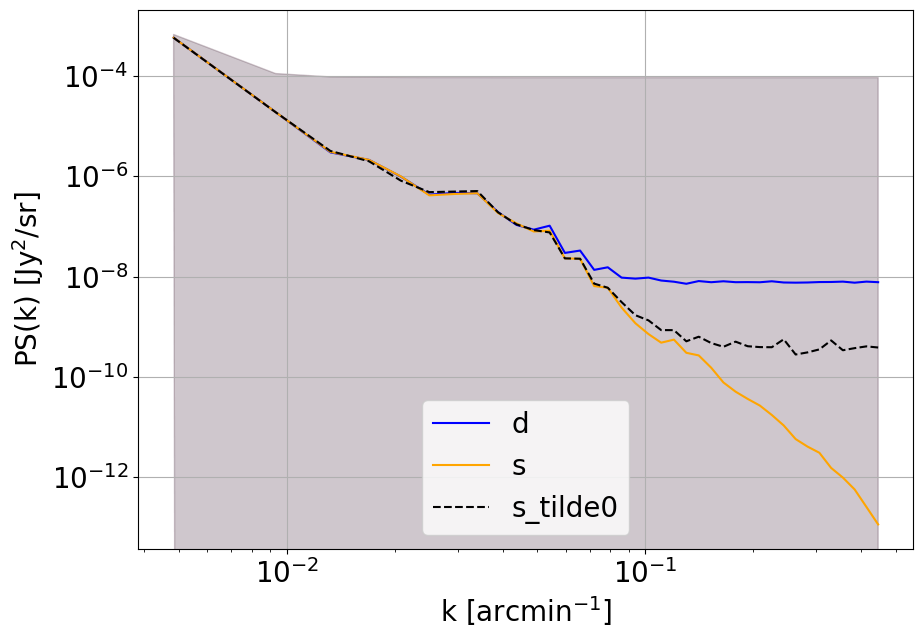

In [ ]:
plot_PS_errorbar(
        np.array([d,s,s_tilde0]),
        labels=['d','s','s_tilde0'],
        colors=['blue','orange','black'],
        styles=['-','-','--']
        )

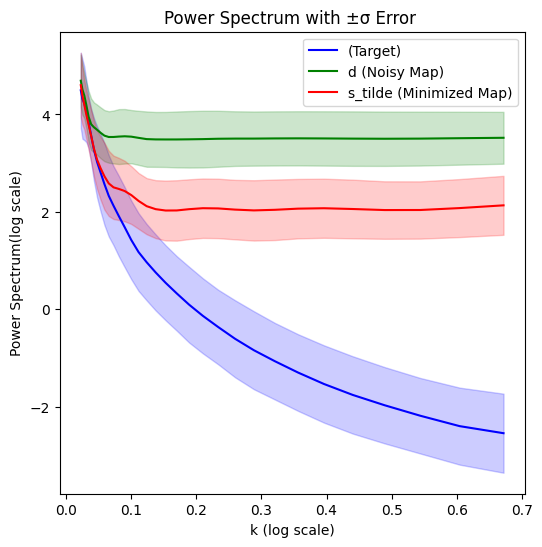

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Load the maps
radio_halo = s #np.load('/content/s_halo.npy')  # Target map
d_map = d #np.load('/content/d_halo.npy')  # Map with noise
s_tilde_map = np.load('/content/separated_component_stilde0_halo (2).npy')  # Minimized map consistent with target

# compute the power spectrum
def compute_power_spectrum(map_data):
    nx, ny = map_data.shape
    fourier_transform = np.fft.fft2(map_data)
    power_spectrum = np.abs(fourier_transform)**2

    # Shift zero frequency to the center
    power_spectrum = np.fft.fftshift(power_spectrum)

    # Compute k values
    kx = np.fft.fftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    k = np.fft.fftshift(k)  # Shift to match the power spectrum

    return k, power_spectrum

# Compute power spectra for all maps
k_radio, ps_radio = compute_power_spectrum(radio_halo)
k_d, ps_d = compute_power_spectrum(d_map)
k_s_tilde, ps_s_tilde = compute_power_spectrum(s_tilde_map)

# Function to bin and smooth the power spectrum
def bin_and_smooth_power_spectrum(k, power_spectrum, num_bins=50, sigma=1.0):
    k_flat = k.flatten() #converting it to 1D array
    ps_flat = power_spectrum.flatten()

    # Exclude k=0
    mask = k_flat > 0
    k_flat = k_flat[mask]
    ps_flat = ps_flat[mask]

    # Bin in log space
    log_k = np.log10(k_flat)
    log_ps = np.log10(ps_flat)

    # Create bins in log space
    bins = np.logspace(np.min(log_k), np.max(log_k), num_bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Bin the power spectrum
    bin_indices = np.digitize(log_k, np.log10(bins))
    mean_ps = np.array([np.mean(log_ps[bin_indices == i]) for i in range(1, len(bins))])
    std_ps = np.array([np.std(log_ps[bin_indices == i]) for i in range(1, len(bins))])

    # Smooth the power spectrum using Gaussian filtering
    mean_ps_smooth = gaussian_filter(mean_ps, sigma=sigma)
    std_ps_smooth = gaussian_filter(std_ps, sigma=sigma)

    return bin_centers, mean_ps_smooth, std_ps_smooth

# Bin and smooth the power spectra
k_bins_radio, mean_ps_radio, std_ps_radio = bin_and_smooth_power_spectrum(k_radio, ps_radio)
k_bins_d, mean_ps_d, std_ps_d = bin_and_smooth_power_spectrum(k_d, ps_d)
k_bins_s_tilde, mean_ps_s_tilde, std_ps_s_tilde = bin_and_smooth_power_spectrum(k_s_tilde, ps_s_tilde)

# Plot the power spectra with ±σ color bands
plt.figure(figsize=(6, 6))

# s.npy
plt.plot(k_bins_radio, mean_ps_radio, label='(Target)', color='blue')
plt.fill_between(k_bins_radio, mean_ps_radio - std_ps_radio, mean_ps_radio + std_ps_radio, color='blue', alpha=0.2)

# (d.npy)
plt.plot(k_bins_d, mean_ps_d, label='d (Noisy Map)', color='green')
plt.fill_between(k_bins_d, mean_ps_d - std_ps_d, mean_ps_d + std_ps_d, color='green', alpha=0.2)

# Minimized Map (s_tilde.npy)
plt.plot(k_bins_s_tilde, mean_ps_s_tilde, label='s_tilde (Minimized Map)', color='red')
plt.fill_between(k_bins_s_tilde, mean_ps_s_tilde - std_ps_s_tilde, mean_ps_s_tilde + std_ps_s_tilde, color='red', alpha=0.2)

# Plot settings
#plt.xscale('loglog')
#plt.yscale('loglog')
#plt.ylim()
plt.xlabel('k (log scale)')
plt.ylabel('Power Spectrum(log scale)')
plt.title('Power Spectrum with ±σ Error ')
plt.legend()
plt.show()

---------------------------------#from here we are implementing all the WPH coefficients along with S11#---------------------------------------

Starting epoch 1...
Computing loss arguments...
Real mask computed : 99 % of coeffs kept !
Imaginary mask computed : 80 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 2.6475
(computed in 23.464s)

Evaluation: 5
L = 2.56765
(computed in 23.316s)

Evaluation: 10
L = 2.15812
(computed in 23.361s)

Evaluation: 15
L = 2.08707
(computed in 23.358s)

Evaluation: 20
L = 1.98774
(computed in 23.341s)

Evaluation: 25
L = 1.93897
(computed in 23.282s)

Evaluation: 30
L = 1.89676
(computed in 23.296s)

Evaluation: 35
L = 1.86403
(computed in 23.266s)

Evaluation: 40
L = 1.83144
(computed in 23.274s)

Evaluation: 45
L = 1.78513
(computed in 23.288s)

Evaluation: 50
L = 1.76212
(computed in 23.345s)

Epoch 1 done !


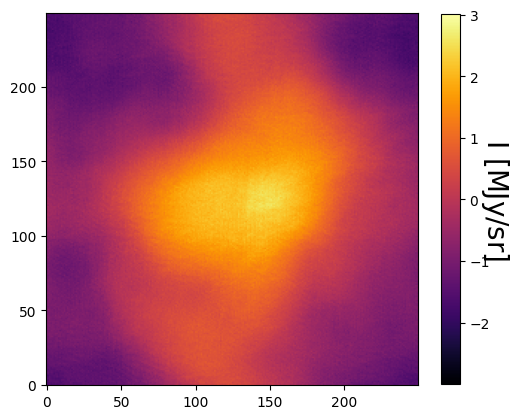

Starting epoch 2...
Computing loss arguments...
Real mask computed : 99 % of coeffs kept !
Imaginary mask computed : 80 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 55
L = 1.88421
(computed in 23.42s)

Evaluation: 60
L = 1.86487
(computed in 23.387s)

Evaluation: 65
L = 1.82982
(computed in 23.391s)

Evaluation: 70
L = 1.77575
(computed in 23.363s)

Evaluation: 75
L = 1.77106
(computed in 23.42s)

Evaluation: 80
L = 1.71487
(computed in 23.403s)

Evaluation: 85
L = 1.69165
(computed in 23.405s)

Evaluation: 90
L = 1.67163
(computed in 23.396s)

Evaluation: 95
L = 1.65507
(computed in 23.384s)

Evaluation: 100
L = 1.63574
(computed in 23.373s)

Evaluation: 105
L = 1.61998
(computed in 23.407s)

Epoch 2 done !


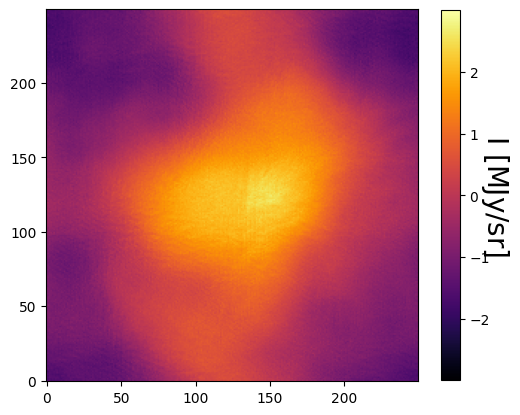

Starting epoch 3...
Computing loss arguments...
Real mask computed : 99 % of coeffs kept !
Imaginary mask computed : 80 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 110
L = 1.77297
(computed in 23.399s)

Evaluation: 115
L = 1.73544
(computed in 23.402s)

Evaluation: 120
L = 1.70367
(computed in 23.401s)

Evaluation: 125
L = 1.68033
(computed in 23.393s)

Evaluation: 130
L = 1.65085
(computed in 23.733s)

Evaluation: 135
L = 1.63345
(computed in 23.402s)

Evaluation: 140
L = 1.6041
(computed in 23.388s)

Evaluation: 145
L = 1.56795
(computed in 23.39s)

Evaluation: 150
L = 1.5526
(computed in 23.404s)

Evaluation: 155
L = 1.54971
(computed in 23.382s)

Evaluation: 160
L = 1.52931
(computed in 23.395s)

Epoch 3 done !


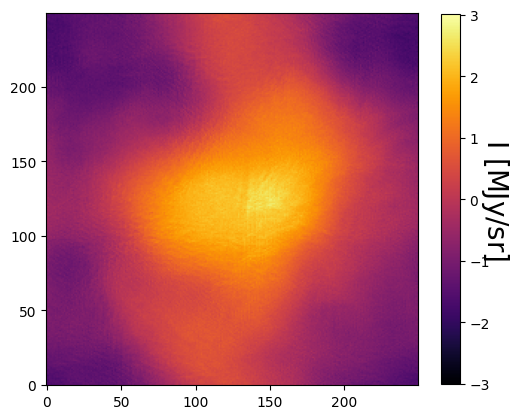

In [ ]:
# Initialization of evaluation count.
eval_cnt = 0
# Initialization of the running map s_tilde.
s_tilde = s_tilde0
# Creation of the loss list.
loss_list = []
# WPH model loading (all the WPH coefficients in the second step).
wph_op.load_model(wph_model)
# Loop of the epochs.
for i in range(n_epoch):
    print("Starting epoch "+str(i+1)+"...")
    # Bring s_tilde from array to tensor.
    s_tilde = torch.from_numpy(s_tilde).to(device)
    print('Computing loss arguments...')
    # Computation of the noise-induced bias and std on the s_tilde map.
    # The bias is only used for style='JMD', but is computed
    # in both cases (no significant additional calculations).
    bias, std = compute_bias_std(s_tilde, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    # Computation of the WPH statistics of "d".
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'BR':
        # In BR's formalism, the target WPH coefficients are the ones of "d".
        # They are split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),
                                   torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JMD':
        # In JMD's formalism, the target WPH coefficients are computed as
        # the ones of "d" corrected from the bias estimated before.
        # They are here also split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),
                                   torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    # Computation of the mask for the WPH statistics threshold.
    mask = compute_mask(2, s_tilde, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    # Beginning of the optimization.
    result = opt.minimize(objective, s_tilde.cpu().ravel(), method=method, jac=True, tol=None,
                          options={"maxiter": n_iter, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    # Reshaping of the running map s_tilde.
    s_tilde = s_tilde.reshape((N, N)).astype(np.float64)
    print("Epoch "+str(i+1)+" done !")
    # Plot of the running map.
    plot(s_tilde)
    # plot_PS(
    #     np.array([d,imtot,s_tilde0, s_tilde]),
    #     labels=['d', 's', 's_tilde0(Epoch ' + str(i + 1) + ')', 's_tilde(Epoch ' + str(i + 1) + ')'],
    #     colors=['blue','orange','black','red'],
    #     styles=['-','-','--','dashdot']
    #     )




In [ ]:
np.save('separated_component.npy', s_tilde)

In [ ]:
#d = np.load("/content/d_halo.npy")
#s = np.load("/content/s_halo.npy")
s_tilde = np.load("/content/separated_component_halos.npy")
s_tilde0 = np.load("/content/separated_component_stilde0_halo (2).npy")

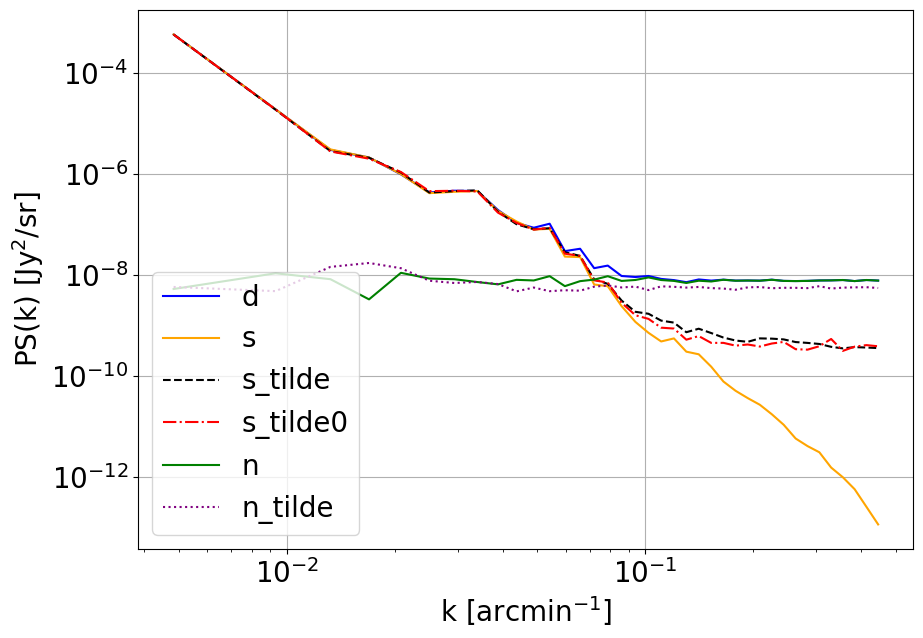

In [ ]:
 plot_PS(
        np.array([d,s,s_tilde, s_tilde0, n, n_tilde]),
        labels=['d','s','s_tilde','s_tilde0', 'n', "n_tilde"],
        colors=['blue','orange','black','red', 'green', 'purple'],
        styles=['-','-','--','dashdot', '-', 'dotted']
        )

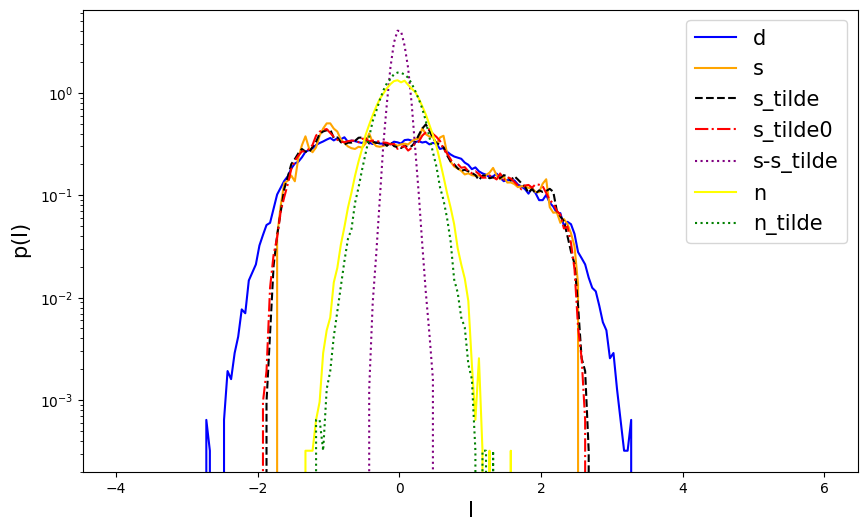

In [ ]:
from CompSep.Library.tools import plot_hist
#color = ['blue', 'orange', 'black']
nature = r'$\rm{I}$'
#plot_hist(np.array([d,s,s_tilde]),labels=[r"$\rm{d}$",r"$\rm{s}$",r"$\rm{\tilde{s}}$"],colors=[color[0],color[1],color[1]],styles=['-','-','--'],n_bins=200,log=True,value_range=(-1,4),fontsize=15,nature=nature)
plot_hist(np.array([d,s,s_tilde, s_tilde0, s-s_tilde, n, n_tilde]),
        labels=['d','s','s_tilde', 's_tilde0', 's-s_tilde', "n", 'n_tilde'],
        colors=['blue','orange','black','red','purple', 'yellow', 'green'],
        styles=['-','-','--','dashdot', 'dotted', '-', 'dotted'],n_bins=200,value_range=(-4,6),log=True)



---



Starting epoch 1...
Iteration 0: Loss = 11795.070113670186 (computed in 0.244s)
Iteration 20: Loss = 11786.410467535936 (computed in 0.002s)
Iteration 40: Loss = 11777.757281076369 (computed in 0.002s)
Iteration 60: Loss = 11769.111256430919 (computed in 0.002s)
Iteration 80: Loss = 11760.472581382504 (computed in 0.002s)
Iteration 100: Loss = 11751.841271344618 (computed in 0.004s)
Iteration 120: Loss = 11743.217303718327 (computed in 0.002s)
Iteration 140: Loss = 11734.600649573948 (computed in 0.002s)
Iteration 160: Loss = 11725.991279446174 (computed in 0.002s)
Iteration 180: Loss = 11717.389164214732 (computed in 0.003s)
Iteration 200: Loss = 11708.79427518927 (computed in 0.003s)
Iteration 220: Loss = 11700.206584084386 (computed in 0.002s)
Iteration 240: Loss = 11691.626062988502 (computed in 0.002s)
Iteration 260: Loss = 11683.052684337477 (computed in 0.002s)
Iteration 280: Loss = 11674.486420893516 (computed in 0.002s)
Iteration 300: Loss = 11665.92724572752 (computed in 0.00

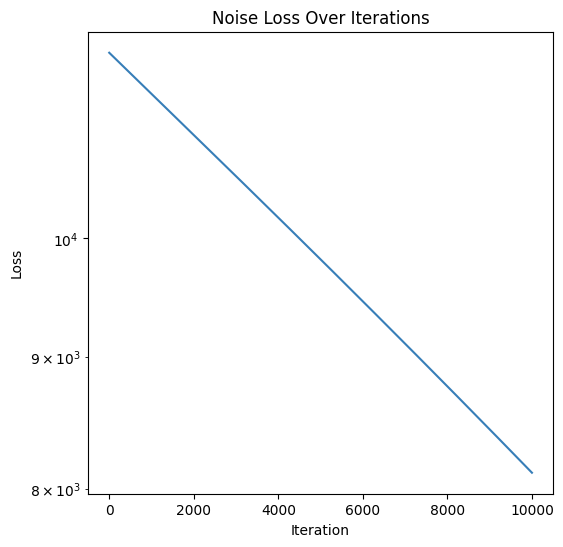

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import time

device = "cpu"
# Define the loss function for c_tilde0
def noise_loss_function(c_tilde0, s_tilde0, d):
    """
    Computes the loss for c_tilde0.

    Parameters
    ----------
    c_tilde0 : torch.Tensor
        Estimated noise component.
    s_tilde0 : torch.Tensor
        Estimated signal component.
    d : torch.Tensor
        Noisy data.

    Returns
    -------
    torch.Tensor
        Loss value.
    """
    d_tensor = torch.from_numpy(d).to(c_tilde0.device) # Move d to the same device as c_tilde0
    s_tilde0_tensor = torch.from_numpy(s_tilde0).to(c_tilde0.device) # Move s_tilde0 to the same device as c_tilde0
    #print(s_tilde0_tensor)

    #return torch.norm(d_tensor - (s_tilde0_tensor + c_tilde0))**2
    # Convert s_tilde0 to a PyTorch tensor before the addition

   #return torch.norm((c_tilde0 - (d_tensor - s_tilde0_tensor)))**2 + torch.sum(torch.abs(c_tilde0 - c_tilde0_old))
    return torch.norm(((d_tensor - s_tilde0_tensor)-c_tilde0))**2 + torch.sum(torch.abs(c_tilde0 - c_tilde0_old))
    # return torch.norm(d - (s_tilde0 + c_tilde0))**2

#d = np.load("/content/d_halo.npy")
#s_tilde0 = np.load("/content/separated_component_stilde0_halo (2).npy")
# Initialize c_tilde0
n_std = 0.3
n = np.random.normal(0, n_std, size=(250, 250))
c_tilde0 = n

c_tilde0 = torch.from_numpy(c_tilde0).to(device).requires_grad_(True)
c_tilde0_old = c_tilde0

# Optimization parameters
n_epoch = 10
n_iter = 1000
learning_rate = 1e-5

# Initialize optimizer
optimizer = optim.Adam([c_tilde0], lr=learning_rate)

# Initialize loss list
noise_loss_list = []


# Loop of the epochs
for epoch in range(n_epoch):
    print(f"Starting epoch {epoch + 1}...")
    for iter in range(n_iter):
        start_time = time.time()

        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = noise_loss_function(c_tilde0, s_tilde0, d)

        # Backpropagate the loss
        loss.backward()
        c_tilde0_old = c_tilde0
        # Update the parameters
        optimizer.step()

        # Record the loss
        noise_loss_list.append(loss.item())

        if iter % 20 == 0:
            print(f"Iteration {iter}: Loss = {loss.item()} (computed in {round(time.time() - start_time, 3)}s)")

    print(f"Epoch {epoch + 1} done!")

# Plot the loss values
plt.figure(figsize=(6,6))
plt.plot(noise_loss_list)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Noise Loss Over Iterations')
plt.show()

In [ ]:
optimized_c_tilde0 = c_tilde0.detach().cpu().numpy()

In [ ]:
n_tilde = optimized_c_tilde0

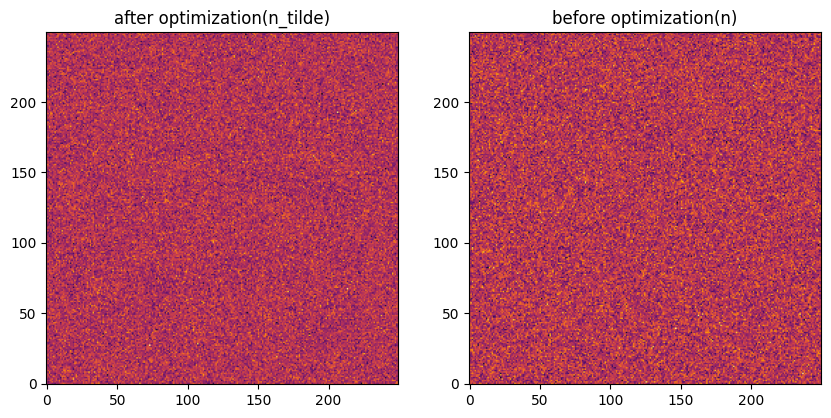

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(optimized_c_tilde0, cmap="inferno", origin="lower")
plt.title("after optimization(n_tilde)")

#plt.colorbar()
t=np.random.normal(0, n_std, size=(250, 250))
plt.subplot(1,2,2)
plt.imshow(t, cmap="inferno", origin ="lower")
plt.title("before optimization(n)")

plt.show()

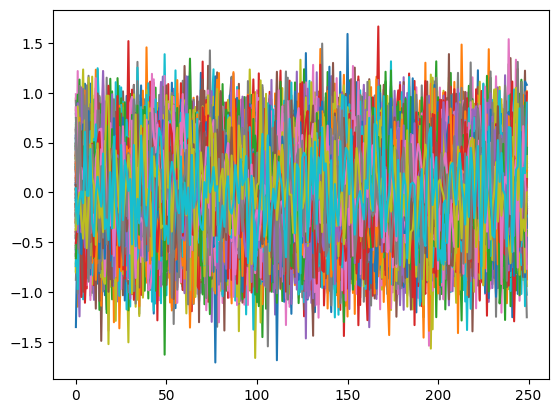

In [ ]:
plt.plot(optimized_c_tilde0-t)


In [ ]:
s_tilde0_up = np.load('/content/separated_component_stilde0.npy')
d_up = np.load('/content/d.npy')

In [ ]:
# Initialization of evaluation count.
eval_cnt = 0
# Initialization of the running map s_tilde.
c_tilde = n
# Creation of the loss list.
loss_list = []
# WPH model loading (all the WPH coefficients in the second step).
wph_op.load_model(wph_model)
# Loop of the epochs.
for i in range(n_epoch):
    print("Starting epoch "+str(i+1)+"...")
    # Bring s_tilde from array to tensor.
    c_tilde = torch.from_numpy(c_tilde).to(device)
    print('Computing loss arguments...')
    # Computation of the noise-induced bias and std on the s_tilde map.
    # The bias is only used for style='JMD', but is computed
    # in both cases (no significant additional calculations).
    bias, std = compute_bias_std(c_tilde, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    # Computation of the WPH statistics of "d".
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'BR':
        # In BR's formalism, the target WPH coefficients are the ones of "d".
        # They are split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),
                                   torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JMD':
        # In JMD's formalism, the target WPH coefficients are computed as
        # the ones of "d" corrected from the bias estimated before.
        # They are here also split into real and imaginary parts.
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),
                                   torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    # Computation of the mask for the WPH statistics threshold.
    mask = compute_mask(2, c_tilde, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    # Beginning of the optimization.
    result = opt.minimize(objective, c_tilde.cpu().ravel(), method=method, jac=True, tol=None,
                          options={"maxiter": n_iter, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    # Reshaping of the running map s_tilde.
    c_tilde = c_tilde.reshape((N, N)).astype(np.float64)
    print("Epoch "+str(i+1)+" done !")
    # Plot of the running map.
    plot(c_tilde)

Starting epoch 1...
Computing loss arguments...
Real mask computed : 100 % of coeffs kept !
Imaginary mask computed : 80 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 52181.32031
(computed in 858.198s)

Evaluation: 5
L = 47509.49219
(computed in 885.33s)

Evaluation: 10
L = 45875.30859
(computed in 896.118s)

Evaluation: 15
L = 39695.69922
(computed in 909.722s)

